In [1]:
from lib.dependencies import *
from lib.time_series_dependencies import *
from lib.models import *
import os
import timeit

## Specifications

These parameters need to be specified prior to running the predictive GAN.

In [11]:
# modes
gp = False
sn = True

# steps
train = False
fixed_input = True
eph = '9999' # the model to read if not training

# paramters
DATASET = 'sine'  # sine, moon, 2spirals, circle, helix
suffix = '_sn' # suffix of output folder 
LATENT_DIM = 2 # latent space dimension
DIM = 512  # 512 Model dimensionality
INPUT_DIM = 2 # input dimension
LAMBDA = 0.1  # smaller lambda seems to help for toy tasks specifically
DROPOUT_RATE = 0.1 # rate of dropout 
lr = 1e-4 # learning rate for the optimizer
CRITIC_ITERS = 5  # how many critic iterations per generator iteration
BATCH_SIZE = 256  # batch size
ITERS = 30000  # 100000, how many generator iterations to train for
log_interval = 1000 # how frequent to write to log and save models 
use_cuda = False
plot_3d = (DATASET == 'helix')
TMP_PATH = 'tmp/' + DATASET + suffix + '/'

if not os.path.isdir(TMP_PATH):
    os.makedirs(TMP_PATH)

## Make generator and discriminator

Initializing generator and discriminator objects. The architectures have been declared in lib.models. 

In [12]:
netG = Generator(LATENT_DIM, DIM, DROPOUT_RATE, INPUT_DIM)
if sn:
    netD = DiscriminatorSN(DIM, INPUT_DIM)
else:
    netD = Discriminator(DIM, INPUT_DIM)

netG.apply(weights_init)
netD.apply(weights_init)

DiscriminatorSN(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

## Train or load model

If in training mode, a WGAN with either SN or GP will be trained on the specified type of synthetic data (sine, circle, half-moon, helix or double-spirals). A log file will be created with all specifications to keep track of the runs. Loss will be plotted against the number of epochs. Randomly generated samples will also be plotted. The frequency at which to save the plots is specified by the parameter 'log_interval'.

If not training, the pre-trained models saved in the tmp path will be loaded. Use 'eph' to specify from which epoch to load the models. 

In [13]:
if train:
    # start writing log
    f = open(TMP_PATH + "log.txt", "w")
    # print specifications
    f.write('gradient penalty: ' + str(gp))
    f.write('\n spectral normalization: ' + str(sn))
    f.write('\n datasest: ' + DATASET)
    f.write('\n hidden layer dimension: ' + str(DIM))
    f.write('\n latent space dimension: ' + str(LATENT_DIM))
    f.write('\n gradient penalty lambda: ' + str(LAMBDA))
    f.write('\n dropout rate: ' + str(DROPOUT_RATE))
    f.write('\n critic iterations per generator iteration: ' + str(CRITIC_ITERS))
    f.write('\n batch size: ' + str(BATCH_SIZE))
    f.write('\n total iterations: ' + str(ITERS))
    f.write('\n')
    # print model structures
    f.write(str(netG))
    f.write(str(netD))
    f.write('\n')
    
    # option of using GPU
    if use_cuda:
        netD = netD.cuda()
        netG = netG.cuda()
    
    # declare optimizers for generator and discriminator
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.9))
    
    # helper tensors for backpropogation
    one = torch.FloatTensor([1])
    mone = one * -1
    if use_cuda:
        one = one.cuda()
        mone = mone.cuda()
    
    # make synthetic data 
    data = make_data_iterator(DATASET, BATCH_SIZE)
    
    # record loss and wasserstein-1 estimate
    losses = []
    wass_dist = []
    
    # start timing
    start = timeit.default_timer()
    
    # start training 
    for iteration in range(ITERS):
        ############################
        # (1) Update D network
        ###########################
        for iter_d in range(CRITIC_ITERS):
            _data = next(data).float()
            if use_cuda:
                _data = _data.cuda()
    
            netD.zero_grad()
    
            # train with real
            D_real = netD(_data)
            D_real = D_real.mean().unsqueeze(0)
            D_real.backward(mone)
    
            # train with fake
            noise = torch.randn(BATCH_SIZE, LATENT_DIM)
            if use_cuda:
                noise = noise.cuda()
            fake = netG(noise)
            D_fake = netD(fake.detach())
            D_fake = D_fake.mean().unsqueeze(0)
            D_fake.backward(one)
    
            # train with gradient penalty
            if gp:
                gradient_penalty = calc_gradient_penalty(netD, _data, fake, BATCH_SIZE, LAMBDA, use_cuda)
                gradient_penalty.backward()
            
            if gp:
                D_cost = abs(D_fake - D_real) + gradient_penalty
            else:
                D_cost = abs(D_fake - D_real)
                
            Wasserstein_D = abs(D_real - D_fake)
            optimizerD.step()
    
        ############################
        # (2) Update G network
        ############################
        netG.zero_grad()
    
        _data = next(data).float()
        if use_cuda:
            _data = _data.cuda()
    
        noise = torch.randn(BATCH_SIZE, LATENT_DIM)
        if use_cuda:
            noise = noise.cuda()
        fake = netG(noise)
        G = netD(fake)
        G = G.mean().unsqueeze(0)
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        
        losses.append([G_cost.cpu().item(), D_cost.cpu().item()])
        wass_dist.append(Wasserstein_D.cpu().item())
        
        if iteration % log_interval == log_interval - 1:
            # save discriminator model
            torch.save(netD.state_dict(), TMP_PATH + 'disc_model' + str(iteration) + '.pth')
            # save generator model
            torch.save(netG.state_dict(), TMP_PATH + 'gen_model' + str(iteration) + '.pth')
            # report iteration number
            f.write('Iteration ' + str(iteration) + '\n')
            # report time
            stop = timeit.default_timer()
            f.write('    Time spent: ' + str(stop - start) + '\n')
            # report loss
            f.write('    Generator loss: ' + str(G_cost.cpu().item()) + '\n')
            f.write('    Discriminator loss: ' + str(D_cost.cpu().item()) + '\n')
            f.write('    Wasserstein distance: ' + str(Wasserstein_D.cpu().item()) + '\n')
            # save frame plot
            noise = torch.randn(BATCH_SIZE, LATENT_DIM)
            if use_cuda:
                noise = noise.cuda()

            plot_data(_data.cpu().numpy(), netG(noise).cpu().data.numpy(), str(iteration), TMP_PATH, plot_3d=plot_3d)
            # save loss plot
            fig, ax = plt.subplots(1, 1, figsize=[10, 5])
            ax.plot(losses)
            ax.legend(['Generator', 'Discriminator'])
            plt.title('Generator Loss v.s Discriminator Loss')
            ax.grid()
            plt.savefig(TMP_PATH + 'loss_trend' + str(iteration) + '.png')
            # save wassertein loss plot
            fig, ax = plt.subplots(1, 1, figsize=[10, 5])
            ax.plot(wass_dist)
            plt.title('Wassertein Distance')
            ax.grid()
            plt.savefig(TMP_PATH + 'wass_dist' + str(iteration) + '.png')
    
    # close log file
    f.close()
else:
    # if not training, load pre-trained models from local files
    netG.load_state_dict(torch.load(TMP_PATH + 'gen_model' + eph + '.pth'))
    netD.load_state_dict(torch.load(TMP_PATH + 'disc_model' + eph + '.pth'))  

## Prediction

For a list of x, use the trained GAN to make multiple predictions for y. For each x, many predictions will be made. A subset is taken depending on the similarity between the generated x and the specified x. 

-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0


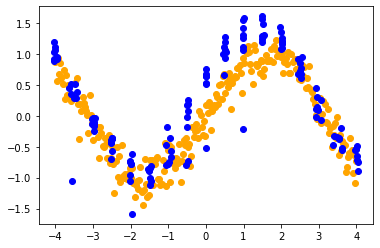

In [15]:
if fixed_input:
    data = make_data_iterator(DATASET, BATCH_SIZE)
    # sine data 
    preds = None
    for x in np.linspace(-4., 4., 17):
        print(x)
        out = predict_fixed(netG, x, 80, 8, INPUT_DIM, LATENT_DIM, use_cuda)
        if preds == None:
            preds = out
        else:
            preds = torch.cat((preds, out))
#         plt.scatter(preds[:, 0], preds[:, 1])
#         plt.show()
    true_dist = next(data)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plt.scatter(true_dist[:, 0], true_dist[:, 1], c='orange', label='Real data')
    plt.scatter(preds[:, 0], preds[:, 1], c='blue', label='Predictions')
    plt.savefig(TMP_PATH + 'fixed_input' + eph + '.jpg')


<Figure size 432x288 with 0 Axes>

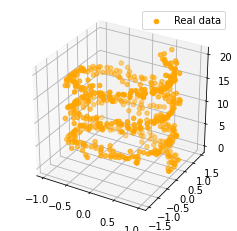

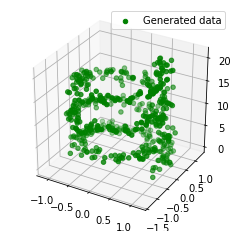

In [72]:

data = make_data_iterator(DATASET, BATCH_SIZE*2)
_data = next(data)
noise = torch.randn(BATCH_SIZE*2, LATENT_DIM)
plot_data(_data.cpu().numpy(), netG(noise).cpu().data.numpy(), str(iteration), TMP_PATH, plot_3d=plot_3d)